# Notebook 3a: ***Probabilistic Programming*** (🧑🏻‍💻+🔥=🎲)

Probabilistic Machine Learning -- Spring 2023, UniTS

<a target="_blank" href="https://colab.research.google.com/github/emaballarin/probml-units/blob/main/notebooks/03a_probabilistic_programming.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

### An introduction

In the words of [Frank Wood](https://www.cs.ubc.ca/~fwood/):

> *"The ultimate aim of probabilistic programming is to allow [people] to define probability distributions as if they were computer programs, and to reason about computer programs as if they were probability distributions."*


More precisely, ***probabilistic programming*** is a programming paradigm aimed at **probabilistic modelling** and **inference**, to be performed in an *automated fashion* via the tools offered by a (usually *general purpose*) programming language.

A *probabilistic programming language* is generally composed of a *host* programming language, endowed with primitives and methods to:
- define probability distributions, random variables, sampling operations, ...; $\rightarrow$ **simulation**
- describe conditioning, *observation* of variables, ...; $\rightarrow$ **inference**

but also:
- interact with probabilistic objects/algorithms in a way that is *transparent*, independently from the specific instance considered.


We can always think of the operations defined in a *PPL* as a composition of **deterministic** computation and **sampling**.


Briefly detouring, one may consider (at surely it is!) *probabilistic programming* as a way to make easier and more direct the computational interaction with probabilistic modelling and its *practical ingredients*. Nonetheless, also the other way round is true! *PP* may also serve as a rigorous specification of procedures involving stochastic *entities*: as a justificatory example, see e.g. [*Bertrand's Paradoxes*](https://zero.sci-hub.ru/5836/6a90d6957add604ff996229fab0a6886/marinoff1994.pdf).

Or (with a stretch) the comic strip below 👇🏻

![image.png](./img/code.jpg)
<br><sub><sup>From <a href="https://www.commitstrip.com/en/2016/08/25/a-very-comprehensive-and-precise-spec/?">CommitStrip.com (August 25th, 2016)</a></sup></sub>

### *Probabilistic Programming **Languages***

Many *PPLs* do exist, the most famous being [`Stan`](https://mc-stan.org/) (which you probably already know!), [`Edward`](https://edwardlib.org/) (historically, now became [`TensorFlow Probability`](https://www.tensorflow.org/probability)), [`Anglican`](https://probprog.github.io/anglican/) (hosted by [Clojure](https://clojure.org/)) and... [**`Pyro`**](https://pyro.ai/), which we will use. Also [`NumPyro`](https://num.pyro.ai/) is worth of notice: generally considered an improvement upon `Pyro` (especially *w.r.t.* internals), though with more *rough edges* all-round.

`Pyro` is a:
- *deep*: allows automatic differentiation of primitives, making it play well with *deep learning* architectures
- *universal*: allows all *probabilistic programs* to be correctly expressed

PPL based on [`PyTorch`](https://pytorch.org/). This provides efficient, flexible and scalable (up to very large datasets) automatic *optimisation-based* inference, GPU-accelerated tensor mathematics (as with *plain* `PyTorch`), and the ability to exploit (internally or explicitly) *automatic differentiation*.

### Modelling / Simulation

A ***statistical model*** is a mathematical description of how some *knowns* (and what's their *form*, since they are known!) and *unknowns* (and ***how** unknown?*; see *e.g.* this [seminal work by E.T. Jaynes](https://bayes.wustl.edu/etj/articles/prior.pdf)!) generate the observed data.

The basic unit of *probabilistic programming* is a *stochastic function*, a function representing a ***generative model*** of the data indeed. In `Pyro`, any function can be viewed as a stochastic function: significantly, functions mixing deterministic Python/`PyTorch` code with *sampling primitives* are generally considered to be *proper* *stochastic function*s.

In [1]:
# If you run this notebook in Colab, do not forget to (uncomment and) run:
# !pip install pyro-ppl

**Sampling in `PyTorch` and in `Pyro`:**

We sample from the *Standard Normal* distribution, *i.e.* $\mathcal{N}(0,1)$

In [1]:
# Standard imports
import torch as th
import pyro

# Using the location/scale parametrisation
loc = 0.0
scale = 1.0

# In PyTorch
stdnormal_torch = th.distributions.Normal(
    loc=loc, scale=scale
)  # Distribution object instantiation
x_torch = stdnormal_torch.rsample()  # Use of the (reparametrised) sampling primitive

# In Pyro
stdnormal_pyro = pyro.distributions.Normal(
    loc, scale
)  # Distribution object instantiation
x_pyro = pyro.sample(
    name="just_a_sample", fn=stdnormal_pyro # calls the stochastic function fn and returns a sample with a specified name.
)  # Use of the sampling primitive

# Printout
print(f"PyTorch sample: {x_torch}; type {type(x_torch)}")
print(f"Pyro sample: {x_pyro}; type {type(x_pyro)}")

PyTorch sample: 0.5215196013450623; type <class 'torch.Tensor'>
Pyro sample: -2.1209146976470947; type <class 'torch.Tensor'>


**Note:** `Pyro` samples are *named*: the *backend* uses these names to uniquely identify sampling statements and change their behavior at runtime depending on how the enclosing stochastic function is defined and/or being used. If no name is specified, one is assigned by default (but it is hard to access it!).

This may turn out to be an inconvenience, but it is also a powerful *feature*: think *e.g.* about the case of multiple samples related to the same event (*e.g.* repeated measurements) *- vs. -* multiple events, each sampled once (*e.g.* many measurements of different entities). In this case, additionally, the `.to_event()` and `.independent()` methods may become useful!

⚠️ In case of doubt, recall the `[batch_size, event_size]` shape of a sample!


Now, we draw multiple samples from the $\mathcal{N}(2,4)$ and $\text{Exp}(0.3)$ distributions, and plot the corresponding histograms with [`Seaborn`](https://seaborn.pydata.org/) (a [`Matplotlib`](https://matplotlib.org/)-based *toolkit* for statistical/probabilistic visualisation).

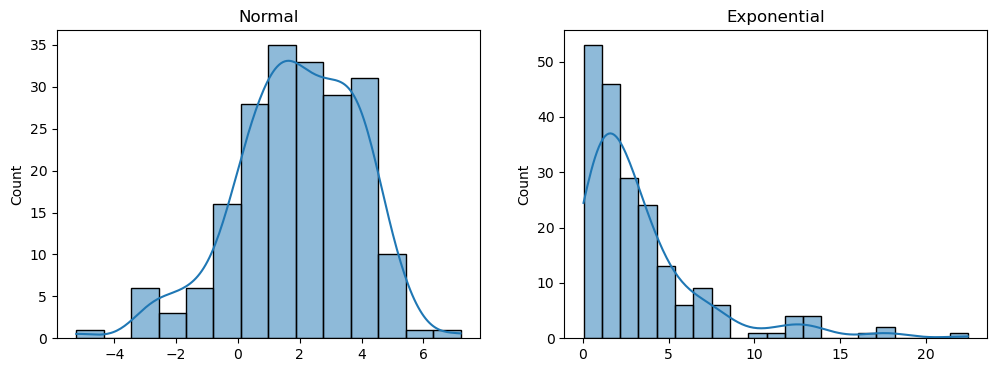

In [5]:
# Some additional imports
import seaborn as sns
import matplotlib.pyplot as plt

# And a convenience alias
import pyro.distributions as dist

# Distributions
normal = dist.Normal(2, 2)
exp = dist.Exponential(0.3)

# Sampling, as a list comprehension
normal_samples = [
    pyro.sample("nn", normal) for i in range(200)
]  # Notice the same sample name: nn
exp_samples = [
    pyro.sample("ne", exp) for i in range(200)
]  # Notice the same sample name: ne

# A more compact way to sample (as a tuple), with implicit sample names
normal_samples = normal.sample((200,))
exp_samples = exp.sample((200,))

# And here we plot!
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(
    normal_samples, ax=axes[0], kde=True
)  # The kde=True argument adds a kernel density estimate
sns.histplot(
    exp_samples, ax=axes[1], kde=True
)  # The kde=True argument adds a kernel density estimate
axes[0].set_title("Normal")
axes[1].set_title("Exponential")
plt.show()

**Example: the *exam grade stochastic model*** 🧑🏻‍🎓

A **very false** (but probably useful didactically) model for the grade of an exam is the following:

The grade of an exam (in tenths) depends on the difficulty of the exam and on the knowledge of the student, according to the following model:

$$\text{difficulty}\sim\text{Bern(0.5)}$$  
$$\text{knowledge}\sim\text{Bern(0.3)}$$  
$$\mu = 4\cdot\text{knowledge}-2\cdot\text{difficulty}+4$$  
$$\text{grade} \sim \mathcal{N}(\mu,1)$$  

We can easily implement this model in `Pyro`:

In [7]:
def describe_grade():
    difficulty = pyro.sample("exam", dist.Bernoulli(0.5))
    is_hard = "hard" if difficulty.item() == 1.0 else "easy"

    knowledge = pyro.sample("knowledge", dist.Bernoulli(0.3))
    is_knowledgeable = "knowledgeable" if knowledge.item() == 1.0 else "not knowledg."

    mu = 4 * knowledge - 2 * difficulty + 4
    grade = pyro.sample("grade", dist.Normal(mu, 1))

    print(f"{is_hard} exam + {is_knowledgeable} student -> grade = {grade}")


for _ in range(10):
    describe_grade()

hard exam + not knowledg. student -> grade = 0.28054773807525635
hard exam + not knowledg. student -> grade = 0.69211745262146
easy exam + knowledgeable student -> grade = 8.72170352935791
hard exam + not knowledg. student -> grade = 0.18934810161590576
hard exam + knowledgeable student -> grade = 5.590681076049805
easy exam + knowledgeable student -> grade = 7.182978630065918
hard exam + not knowledg. student -> grade = 1.1359798908233643
hard exam + not knowledg. student -> grade = 1.8754606246948242
hard exam + knowledgeable student -> grade = 5.172354698181152
easy exam + knowledgeable student -> grade = 6.8722052574157715


easy exam + not knowledg. student -> grade = 4.031743049621582


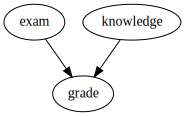

In [8]:
pyro.render_model(describe_grade)

**Another example: the *weather stochastic model*** 🌦️

Suppose we want to reason about how temperature (in *degrees Celsius*) interacts with sunny and cloudy weather. We can define a simple stochastic function describing the interaction:


- $\mathcal{N}(12,25) \; \text{for cloudy weather}$  
- $\mathcal{N}(23,36) \; \text{for sunny weather}$

We also suppose to know that the weather is cloudy with probability 0.3.

In `Pyro`, we can implement this model as follows:

In [11]:
# pyro.set_rng_seed(0)


def weather():
    # generate a binary sample
    is_cloudy_dist = pyro.sample("cloudy", dist.Bernoulli(0.3))

    # convert binary sample into categorical
    is_cloudy = "cloudy" if is_cloudy_dist.item() == 1.0 else "sunny"

    loc_temp = {"cloudy": 12.0, "sunny": 23.0}[
        is_cloudy
    ]  # Using implicit bool-to-int casting
    scale_temp = {"cloudy": 5.0, "sunny": 6.0}[
        is_cloudy
    ]  # Using implicit bool-to-int casting

    temp = pyro.sample("temp", dist.Normal(loc_temp, scale_temp))

    return {"weather": is_cloudy, "temp": temp.item()}


for _ in range(5):
    print(weather())

{'weather': 'sunny', 'temp': 27.3343505859375}
{'weather': 'cloudy', 'temp': 8.331315994262695}
{'weather': 'sunny', 'temp': 26.859893798828125}
{'weather': 'sunny', 'temp': 22.956039428710938}
{'weather': 'cloudy', 'temp': 17.690462112426758}


Additionally, we could use this stochastic function to model the sales of ice cream based on the weather. 🍨

In [13]:
def ice_cream_sales():
    is_cloudy, temp = weather()
    expected_sales = 200.0 if (is_cloudy == 1 and temp > 35.0) else 20.0
    sales = pyro.sample("ice_cream", pyro.distributions.Normal(expected_sales, 10.0))
    return sales.item()


for _ in range(5):
    print(ice_cream_sales())

24.756057739257812
20.625051498413086
22.562423706054688
28.44805335998535
38.965553283691406


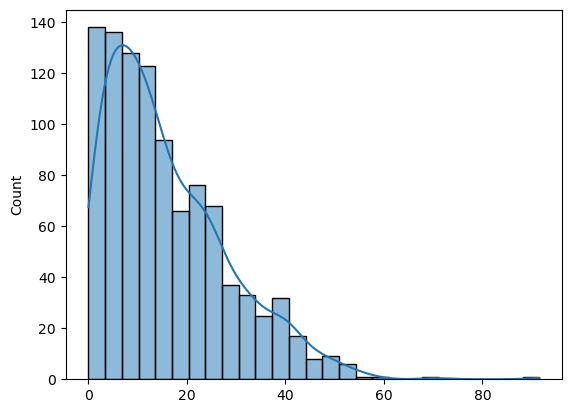

In [17]:
sns.histplot([ice_cream_sales() for _ in range(1000)], kde=True)
plt.show()

Something seems off... 🤔  
Negative ice cream sales? 🤯

(*emojis* kindly provided by GitHub Copilot)

In [15]:
def ice_cream_sales():
    is_cloudy, temp = weather()
    expected_sales = 200.0 if (is_cloudy == 1 and temp > 35.0) else 20.0
    sales = pyro.sample("ice_cream", pyro.distributions.HalfNormal(expected_sales, 10))
    return sales.item()

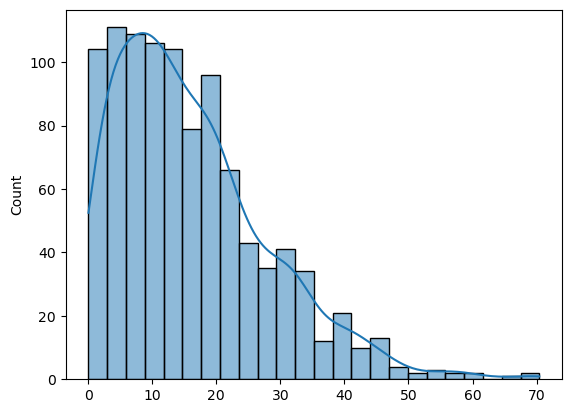

In [16]:
sns.histplot(
    [ice_cream_sales() for _ in range(1000)], kde=True
)  # The kde=True argument adds a kernel density estimate
plt.show()

Or we could have used just a truncated Normal.

And so on, and so forth...


**Note:** in `Pyro`, you can use the `obs=...` primitive to condition a stochastic function on observed data (usually, they are the output of the function).

### Inference

The purpose of **statistical inference** is that of using a statistical model to infer the values of the unknowns that are (most) consistent with observed data.


|Frequentist interpretation|Bayesian interpretation|
|           :-:            |          :-:          |
|Probability measures a proportion of outcomes. | Probability measures the believability in an event. |
|There is randomness in our estimation of the parameters, but not in the parameters themselves, which are considered as fixed, *true*.| Parameters are treated as random variables and our belief about these parameters is updated in the light of data.|

#### Bayesian inference (a super-brief recap)

Within the Bayesian paradigm we do not *estimate* parameters, we compute their distribution based on our *priors* and given the observed *data*.

The posterior probability is derived according to Bayes' theorem

$$ p(\theta|x) = \frac{p(x|\theta)p(\theta)}{p(x)} $$

and the idea of uncertainty is preserved by the specific interpretation attributed to the involved terms:

- **prior probability** $p(\theta)$ = (degree of) belief of event occurring, before observing any evidence
- **evidence** $p(x)$ = observed data
- **likelihood** $p(x|\theta)$ = compatibility of the evidence with the given hypothesis
- **posterior probability** $p(\theta|x)$ = updated belief, given the evidence

#### Approximate inference

Prior $p(\theta)$ and likelihood $p(x|\theta)$ are functions usually known as part of the model, whereas the computation of the *normalization factor*

$$p(x) = \int_\theta p(x|\theta) p (\theta) d \theta$$

can easily become intractable as the space of parameters becomes high-dimensional.

**Example of an intractable posterior**

Suppose we are trying to figure out how much an object weighs, but the scale we’re using is unreliable and gives slightly different answers every time we weigh the same object. We could try to compensate for this variability by integrating the noisy measurement information with a guess based on some *prior knowledge* about the object.

*E.g.*:

$$\text{weight} \, | \, \text{guess} \sim \mathcal{N}(\text{guess}, 1)$$
$$ \text{measurement} \, | \, \text{guess}, \text{weight} \sim \mathcal{N}(\text{weight}, 0.75^2) $$

In this example weight is the parameter of interest, guess is a hyper-parameter and measurement is what we observe.

In `Pyro`, we can implement this model as follows:

In [42]:
def scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    measurement = pyro.sample("measurement", dist.Normal(weight, 0.75))
    return measurement.item()

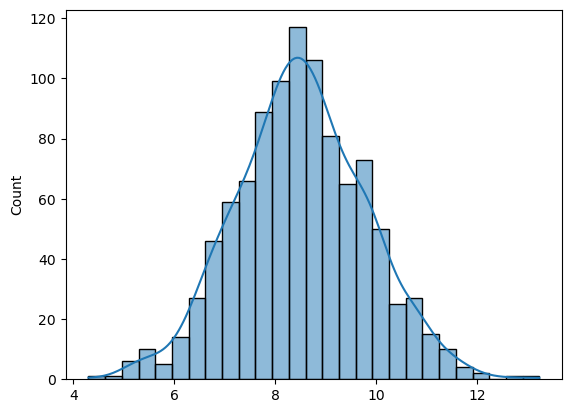

In [43]:
# Example: guess = 8.5
scale(8.5)

sns.histplot(
    [scale(8.5) for _ in range(1000)], kde=True
)
plt.show()

Such model is quite simple, and we are able to determine the posterior distribution of interest analytically. 

In general, however, the exact computation of the posterior of an arbitrary stochastic function is intractable. Even the `scale` model with a (probably even realistic) *non-linear function* may become intractable.

*E.g.* the following model:

In [46]:
def intractable_scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    measurement = pyro.sample(
        "measurement", dist.Normal((lambda x: x + x * th.sin(x))(weight), 0.75)
    )
    return measurement.item()

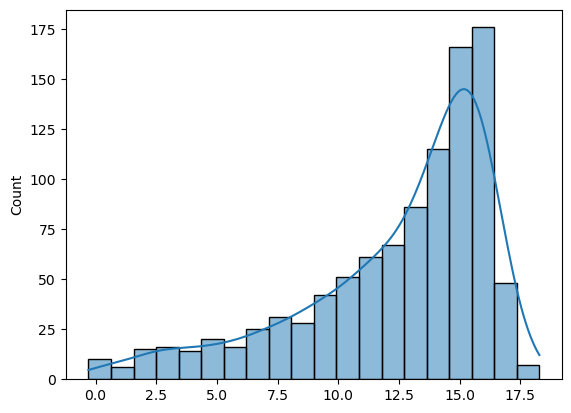

In [47]:
sns.histplot(
    [intractable_scale(8.5) for _ in range(1000)], kde=True
)
plt.show()

***Approximate inference*** addresses the need of applying Bayesian learning to more complex problems, and to high-dimensional datasets we might be dealing with in machine learning.

Examples of approximate inference include Variational Bayesian methods, Markov chain Monte Carlo, Markov Random Fields and Bayesian Networks.

We can identify two main categories of approximate inference:
- **Deterministic methods** substitute inference with optimization problems;
- **Stochastic methods** turn the problem of inference into a problem of sampling from the posterior distribution of interest.

### Further reading / resources 📖
- [S. Wood, *"Core Statistics"*](https://www.maths.ed.ac.uk/~swood34/core-statistics.pdf)
- [Pyro documentation](https://docs.pyro.ai/)
- [C.D. Pilon, *"Probabilistic Programming & Bayesian Methods for Hackers"*](https://dataorigami.net/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/)
- [A. Clayton, *"Bernoulli's Fallacy: Statistical Illogic and the Crisis of Modern Science"*](https://raspiwww.ballarin.cc/cdn/zotero_book_url/AClayton_BernoullisFallacy.pdf)